In [2]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)
import pystan
import scipy.stats as stats
import qgrid

In [53]:
#qgrid.nbinstall(overwrite=True)

In [3]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 50)

In [4]:
pga = pd.read_csv(filepath_or_buffer='data/rshot-2016.txt', sep=';', skipinitialspace=True)
pga.info()

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,21,22,27,33,34,35,39,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141966 entries, 0 to 1141965
Data columns (total 43 columns):
Tour Code                          1141966 non-null object
Tour Description                   1141966 non-null object
Year                               1141966 non-null int64
Tourn.#                            1141966 non-null int64
Player #                           1141966 non-null int64
Course #                           1141966 non-null int64
Permanent Tournament #             1141966 non-null int64
Player First Name                  1141966 non-null object
Player Last Name                   1141966 non-null object
Round                              1141966 non-null int64
Tournament Name                    1141966 non-null object
Course Name                        1141966 non-null object
Hole                               1141966 non-null int64
Hole Score                         1141601 non-null float64
Par Value                          1141966 non-null int64
Yardage  

In [6]:
# pga[['Player #', 'Player First Name', 'Player Last Name']].drop_duplicates()
top100_names = pd.read_csv(filepath_or_buffer='data/top100.txt', sep=',', header=None)
top10_names = top100_names[0:10]
for i, x in enumerate(top10_names.as_matrix()):
    print i+1,' - ', x[0], x[1]

1  -  Jason Day
2  -  Rory McIlroy
3  -  Brooks Koepka
4  -  Sergio Garcia
5  -  Dustin Johnson
6  -  Adam Scott
7  -  Ryan Palmer
8  -  Justin Rose
9  -  Phil Mickelson
10  -  Hudson Swafford


In [8]:
raw_tournaments =  pga[['Date', 'Tournament Name', 'Course Name', 'Course #']].drop_duplicates().as_matrix()
excluded = ["World Golf Championships-Dell Match Play", "AT&T Pebble Beach Pro-Am" ]
tournaments = raw_tournaments[0]
for i in range(1, len(raw_tournaments)):
    if raw_tournaments[i, 1] != raw_tournaments[i-1, 1]:
        tournaments = np.vstack((tournaments,raw_tournaments[i]))
for exclude in excluded:
    tournaments = tournaments[tournaments[:, 1] != exclude ]
course_map = dict(zip (tournaments[:, 3].tolist(), range(1,39)))

In [9]:
raw_players = pga[['Player #', 'Player First Name', 'Player Last Name']].drop_duplicates()
players_ids = []
for name in top100_names.as_matrix():
    players_ids.append(raw_players[(raw_players['Player Last Name'] == name[1]) & (raw_players['Player First Name'] == name[0])]['Player #'].drop_duplicates().tolist()[0])



In [11]:
shots = pga[pga['Player #'].isin(players_ids)][['Player #', 'Course #', 'Round', 'Shot', 'Strokes Gained/Baseline', 'Strokes Gained Category']]
shots

,Player #,Course #,Round,Shot,Strokes Gained/Baseline,Strokes Gained Category
71,8075,552,1,1,0.191,Off the Tee
72,8075,552,1,2,-0.245,Approach to the Green
73,8075,552,1,3,0.141,Putting
74,8075,552,1,4,0.002,Putting
75,8075,552,1,1,-0.356,Approach to the Green
76,8075,552,1,2,-0.313,Around the Green
77,8075,552,1,3,0.772,Putting
78,8075,552,1,1,0.165,Off the Tee
79,8075,552,1,2,0.508,Approach to the Green
80,8075,552,1,3,0.333,Putting


In [11]:
player_map = dict(zip(players_ids, range(1,101)))

In [13]:
raw_rounds = pd.DataFrame(scores.reset_index(name = "Score")).as_matrix()

In [14]:
rounds = np.empty((1, 4), dtype='int')
for t in tournaments:
    rounds = np.vstack((rounds, raw_rounds[raw_rounds[:, 1] == t[3]]))
rounds = rounds[1:,:] 
rounds

array([[ 8075,   552,     1,    72],
       [ 8075,   552,     2,    69],
       [ 8075,   552,     3,    71],
       ..., 
       [40026,   688,     2,    70],
       [40026,   688,     3,    69],
       [40026,   688,     4,    68]])

In [15]:
datum = sorted([[player_map[i[0]], course_map[i[1]], i[3]] for i in rounds],key = lambda (el): el[0])
pp, cc, y = zip(*datum)

In [41]:
rounds = np.zeros([100])
for r in pp:
    rounds[r-1] += 1
rounds = rounds.tolist()

In [20]:

code = """
data {
  int N;
  int N_P;
  int N_C;
  int y[N];
  int pp[N];
  int cc[N];
  real rounds[N_P];
}
# Trending Model
parameters {
  real<lower=-3, upper=3> alpha[N_C];
  real<lower=0, upper=7> sigma[N_P];
  real<lower=65, upper=75> tau[N_P];
  real<lower=-2, upper=2> beta[N_P];
} 
model {
  real trend = 0;
  real m = 1;
  real scale = 1.0/70.0;  #  average score
  y[1] ~ normal(alpha[cc[1]] + tau[pp[1]], sigma[pp[1]]);
  for (n in 2:N) {
    if (pp[n] != pp[n-1])
      m = n;
    trend = 1 - beta[pp[n]]*scale/2 + beta[pp[n]]*(n-m)*scale/rounds[pp[n]];
    y[n] ~ normal(alpha[cc[n]] + tau[pp[n]]*trend, sigma[pp[n]]);
    
  } 
}

"""
data = {
    'N': len (y),
    'y': y,
    'pp' : pp,
    'cc' : cc,
    'N_P' : 100,
    'N_C' : 38,
    'rounds' : rounds
}

fit = pystan.stan(model_code=code, data=data, iter=1000, chains=4)
print fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_873a3fab942e8e5fad9917ced39aacae NOW.


Inference for Stan model: anon_model_873a3fab942e8e5fad9917ced39aacae.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]   -0.37    0.02   0.29  -0.95  -0.56  -0.37  -0.17   0.19  141.0   1.02
alpha[1]   -1.15    0.03   0.29  -1.73  -1.34  -1.15  -0.95  -0.58  133.0   1.02
alpha[2]   -1.51    0.03   0.35   -2.2  -1.75   -1.5  -1.29  -0.86  168.0   1.02
alpha[3]   -0.29    0.03   0.33  -0.95   -0.5  -0.29  -0.07   0.36  165.0   1.02
alpha[4]   -2.13    0.02   0.32  -2.76  -2.35  -2.13  -1.91  -1.48  171.0   1.02
alpha[5]   -0.98    0.03   0.41  -1.78  -1.25  -0.99  -0.72  -0.17  237.0   1.01
alpha[6]    -2.8    0.01   0.17  -2.99  -2.93  -2.84  -2.71  -2.38  262.0   1.02
alpha[7]   -0.63    0.03   0.35   -1.3  -0.86  -0.64  -0.39   0.05  179.0   1.02
alpha[8]    2.81  6.9e-3   0.16   2.39   2.72   2.85   2.93   2.99  562.0   1.01
alp

In [147]:
fit.plot(['alpha'])
plt.tight_layout()

AttributeError: 'LinearRegression' object has no attribute 'plot'

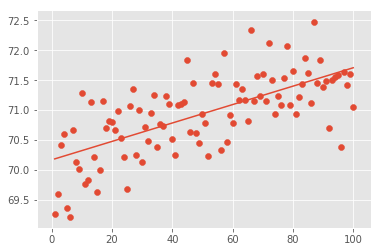

In [99]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

variates = [[i] for i in range(1, len (average_adusted_score)+1)]

clf.fit(variates, average_adusted_score)
plt.plot(variates, clf.predict(variates))
plt.scatter(variates, average_adusted_score)

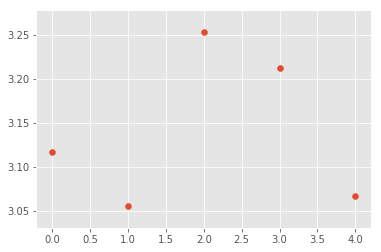

In [153]:
sigma = [round(means[i][0],2) for i in range(38,138)]
num_per_bin = 20
hist = []
bins = [i for i in range(0, len (average_adusted_score)/num_per_bin)]
for i in bins:
    hist.append(np.average(sigma[i*num_per_bin:(i+1)*num_per_bin]))      
plt.scatter(bins, hist)
# plt.scatter(variates, sigma)

[-0.1242] [ 0.1588]


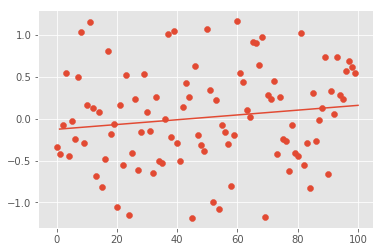

In [101]:
trend = [round(means[i][0],2) for i in range(238,338)]
clf.fit(variates, trend)
plt.plot(variates, clf.predict(variates))
plt.scatter(range(0, len (trend)), trend)
print clf.predict([[1]]), clf.predict([[100]])

In [122]:
# player = top10_ord[top10_ord[:, 1] == "Johnson"][:,  5]
# plt.scatter(np.arange(0, len(player)), player)

In [ ]:
# y = []
# c = []
# for i, p in enumerate(players):
#     y.append(top10_ord[top10_ord[:, 0] == p][:,3].tolist())
#     c.append([course_map[cc] for cc in top10_ord[top10_ord[:, 0] == p][:,1].tolist()])   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68d236bb8fdd18a24e5ada7f59123717 NOW.


Inference for Stan model: anon_model_68d236bb8fdd18a24e5ada7f59123717.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  71.75    0.62   8.43  57.22  65.68  71.55  76.73  89.59  186.0    1.0
beta   -0.03  8.9e-3   0.12  -0.28  -0.11  -0.03   0.06   0.18  186.0    1.0
sigma    3.9    0.03   0.37   3.28   3.64   3.86   4.11   4.74  138.0   1.01
yhat    69.5    0.23   4.06   61.4  66.63  69.71   72.6  77.01  322.0    1.0
lp__  -114.8    0.09   1.39 -118.3 -115.6 -114.5 -113.8 -113.2  231.0    1.0

Samples were drawn using NUTS at Fri Jul 14 23:19:10 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


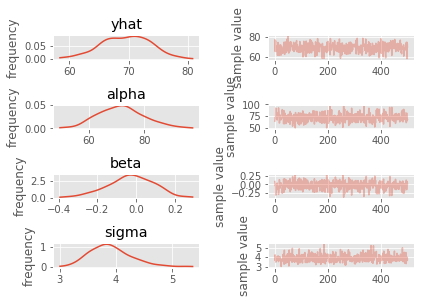

In [130]:
#    Autoregressive model
# parameters {
#   real<lower=-3, upper=3> alpha[N_C];
#   real beta[N_P];
#   real<lower=0> sigma[N_P];
#   real<lower=65, upper=75> tau[N_P];
# } 
# model {
#   y[1] ~ normal(alpha[cc[1]] + tau[pp[1]], sigma[pp[1]]);
#   for (n in 2:N) {
#     if (pp[n-1] == pp[n])
#       y[n] ~ normal(alpha[cc[n]] + tau[pp[n]] + beta[pp[n]] * y[n-1]/72, sigma[pp[n]]);
#     else 
#       y[n] ~ normal(alpha[cc[n]] + tau[pp[n]], sigma[pp[n]]);
#   } 
# }


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_965b4666dd8540917d7c90ccc082fa72 NOW.


Inference for Stan model: anon_model_965b4666dd8540917d7c90ccc082fa72.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     69.87    0.02   0.48   68.9  69.53  69.89  70.19   70.8  464.0    1.0
sigma   3.89    0.02   0.35   3.27   3.65   3.86   4.11   4.65  451.0    1.0
lp__  -113.2    0.06   0.95 -115.5 -113.6 -112.9 -112.5 -112.2  262.0   1.01

Samples were drawn using NUTS at Thu Jul 13 19:01:27 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


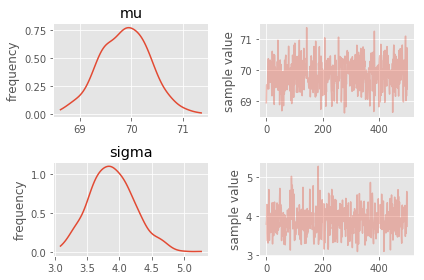

In [90]:
code = """
data {
  int<lower=0> N;
  real y[N]; 
}
parameters {
  real mu;
  real<lower=0> sigma;
} 
model {
  y ~ normal(mu, sigma);
}
"""
data = {
    'N': len (player),
    'y': [x*1.001 for x in player.tolist()]
}

fit = pystan.stan(model_code=code, data=data, iter=1000, chains=1)
print fit
fit.plot(['mu', 'sigma'])
plt.tight_layout()

Inference for Stan model: anon_model_99d207a6cd8130845e3e36373aac0a77.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -1.26    0.03   0.49  -2.16  -1.56  -1.27  -0.93  -0.23  345.0    1.0
beta[0]   0.38  6.1e-3   0.13   0.13   0.29   0.38   0.46   0.62  427.0    1.0
sigma     3.21    0.01   0.29    2.7   3.02   3.19    3.4   3.84  410.0    1.0
yhat     67.79    0.14   2.95  61.85  65.51  67.83  69.92  73.59  432.0    1.0
lp__    -105.9    0.09   1.43 -109.2 -106.7 -105.5 -104.9 -104.2  272.0    1.0

Samples were drawn using NUTS at Wed Jul 12 07:49:19 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


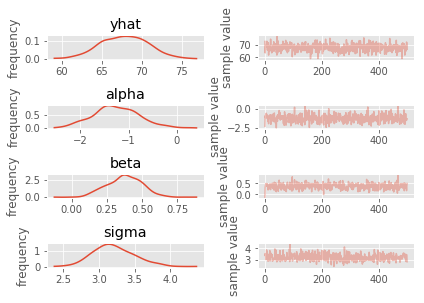

In [51]:
print fit
fit.plot(['yhat', 'alpha','beta', 'sigma'])
plt.tight_layout()